<a href="https://colab.research.google.com/github/asamiei/plasma_cell_dyscrasia_marrow_quant/blob/main/CD138_Binary_classification_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Takes in a 40 x 40 image (RGB), and determines if it is CD138+(=1) or Negative(=0) 
# The cell should be roughly at the center, with a radius of ~25-35 pixels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import scipy
import glob

import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import albumentations as A
!pip install scikit-image==0.18.3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
!pip install segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
!pip install tensorflow-addons
#!pip install -U albumentations

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


# Creating Training Dataset

In [ ]:
from albumentations import (
    HorizontalFlip, ShiftScaleRotate, RandomRotate90,
    Transpose, Flip, Compose, Rotate, OneOf, RandomBrightnessContrast)


transform = A.Compose([
                    A.HorizontalFlip(p=0.5), 
                    A.ShiftScaleRotate(p=0.75, scale_limit=0.3, shift_limit=0.20, rotate_limit=90),
                    A.RandomRotate90(p=0.5),
                    A.Rotate(p =0.5, limit=90, interpolation=cv2.INTER_CUBIC)
                    ])


def visualize(image):
    plt.figure(figsize=(2,2))
    plt.axis('on')
    plt.imshow(image)

In [ ]:
#!pip install scikit-image==0.18.3
from skimage.color import rgb2hed, hed2rgb

def Deconvolve_DAB(img):
    # Separate the stains from the IHC image
    ihc_hed = rgb2hed(img)

    # Create an RGB image for each of the stains
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
    ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
    ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))
    
    #return img
    return (ihc_d * 255).astype(np.uint8)


In [ ]:
# Getting a list of images
normal_images = glob.glob("/content/drive/MyDrive/CD138_project_individual_cells/Negative/*")

# Combining all the images into one numpy array
normal_images_dataset = [cv2.resize(cv2.imread(fname), (40,40)) for fname in normal_images]
normal_images_dataset = np.array([Deconvolve_DAB(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in normal_images_dataset])


# Storing/pickling
#normal_images_dataset.dump('***.npy')

In [ ]:
np.shape(normal_images_dataset)

(3129, 40, 40, 3)

In [ ]:
# Augmenting the dataset
Aug_normal_images_dataset = []                 

for k in range(5):
    for i in range(np.size(normal_images_dataset, axis = 0)):
        transformed = transform(image= normal_images_dataset[i,:,:,:].astype(np.uint8))
        Aug_normal_images_dataset.append(transformed['image'])

Aug_normal_images_dataset = np.array(Aug_normal_images_dataset)
#visualize(transformed['image'])

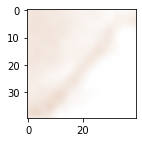

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(Aug_normal_images_dataset[14])

In [ ]:
normal_images_dataset = np.concatenate((normal_images_dataset, Aug_normal_images_dataset), axis = 0)

In [ ]:
np.shape(normal_images_dataset)

(18774, 40, 40, 3)

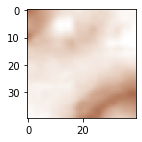

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(normal_images_dataset[16])

In [ ]:
np.max(normal_images_dataset[6])

255

In [ ]:
CD138_images = glob.glob("/content/drive/MyDrive/CD138_project_individual_cells/CD138/*")

# Combining all the images into one numpy array
CD138_images_dataset = [cv2.resize(cv2.imread(fname), (40,40)) for fname in CD138_images]
CD138_images_dataset = np.array([Deconvolve_DAB(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in CD138_images_dataset])

# Storing/pickling
#CD138_images_dataset.dump('***.npy')

In [ ]:
larger_CD138_images_dataset = CD138_images_dataset

In [ ]:
np.shape(larger_CD138_images_dataset)

(792, 40, 40, 3)

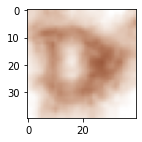

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(CD138_images_dataset[16])

In [ ]:
# Augmenting the dataset
Aug_larger_CD138_images_dataset = []                 

for k in range(18):
    for i in range(np.size(larger_CD138_images_dataset, axis = 0)):
        transformed = transform(image= larger_CD138_images_dataset[i,:,:,:].astype(np.uint8))
        Aug_larger_CD138_images_dataset.append(transformed['image'])

Aug_larger_CD138_images_dataset = np.array(Aug_larger_CD138_images_dataset)
#visualize(transformed['image'])

In [ ]:
larger_CD138_images_dataset = np.concatenate((larger_CD138_images_dataset, Aug_larger_CD138_images_dataset), axis = 0)

In [ ]:
np.shape(larger_CD138_images_dataset)

(15048, 40, 40, 3)

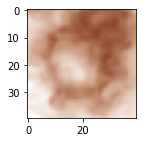

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(larger_CD138_images_dataset[3])

In [ ]:
# Combining normal and CD138 images
combined_image_dataset = np.concatenate((normal_images_dataset, larger_CD138_images_dataset), axis = 0).astype(np.uint16)

In [ ]:
np.shape(combined_image_dataset)

(33822, 40, 40, 3)

In [ ]:
# Assigning a label to each image
    # 0 = Normal
    # 1 = CD138
normal_label = np.zeros((np.size(normal_images_dataset, axis = 0)))

CD138_label = np.ones((np.size(larger_CD138_images_dataset, axis = 0)))

combined_label_dataset = np.concatenate((normal_label, CD138_label))

In [ ]:
np.shape(combined_label_dataset)

(33822,)

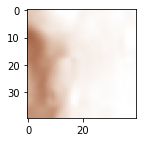

0.0

In [ ]:
plt.figure(figsize=(2,2))
img_ = combined_image_dataset[4]
plt.imshow(img_)
plt.show()
combined_label_dataset[4]

# Creating Validation Dataset

In [ ]:
# Getting a list of images
val_normal_images = glob.glob("/content/drive/MyDrive/CD138_project_individual_cells/Validation/Negative_Val/*")

# Combining all the images into one numpy array
val_normal_images_dataset = [cv2.resize(cv2.imread(fname), (40,40)) for fname in val_normal_images]
val_normal_images_dataset = np.array([Deconvolve_DAB(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in val_normal_images_dataset])


In [ ]:
np.shape(val_normal_images_dataset)

(220, 40, 40, 3)

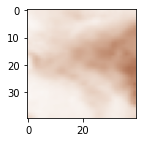

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(val_normal_images_dataset[3])
plt.show()

In [ ]:
val_CD138_images = glob.glob("/content/drive/MyDrive/CD138_project_individual_cells/Validation/CD138_val/*")



# Combining all the images into one numpy array
val_CD138_images_dataset = [cv2.resize(cv2.imread(fname), (40,40)) for fname in val_CD138_images]
val_CD138_images_dataset = np.array([Deconvolve_DAB(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in val_CD138_images_dataset])


In [ ]:
np.shape(val_CD138_images_dataset)

(143, 40, 40, 3)

In [ ]:
# Combining normal and CD138 validation images
val_combined_image_dataset = np.concatenate((val_normal_images_dataset, val_CD138_images_dataset), axis = 0).astype(np.uint16)

In [ ]:
# Assigning a label to each image
    # 0 = Normal
    # 1 = CD138
val_normal_label = np.zeros((np.size(val_normal_images_dataset, axis = 0)))

val_CD138_label = np.ones((np.size(val_CD138_images_dataset, axis = 0)))

val_combined_label_dataset = np.concatenate((val_normal_label, val_CD138_label))

In [ ]:
np.shape(val_combined_label_dataset)

(363,)

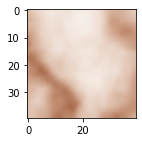

0.0

In [ ]:
plt.figure(figsize=(2,2))
img_ = val_combined_image_dataset[50]
plt.imshow(img_)
plt.show()
val_combined_label_dataset[50]

# CNN

In [ ]:
SIZE = 40

#Use customary x_train and y_train variables
x_train = combined_image_dataset
y_train = combined_label_dataset

x_val = val_combined_image_dataset
y_val = val_combined_label_dataset 

# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)


INPUT_SHAPE = (SIZE, SIZE, 3)   #change to (SIZE, SIZE, 3)


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2), padding='same'))

model.add(Flatten())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))  



model.compile(loss='binary_crossentropy',
              optimizer='adam',             
              metrics= ['accuracy'])

print(model.summary())     




##########################################################

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience= 75, restore_best_weights= True)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/saved_models/CD138_Binary_classification_40x40_April_14th.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)



history = model.fit(x_train, 
                         y_train, 
                         batch_size = 64, 
                         verbose = 1, 
                         epochs = 300,      
                         validation_data=(x_val,y_val),
                         callbacks=[es, mc],
                         shuffle = True
                     )



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 38, 38, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 38, 38, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 19, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 17, 17, 64)       2

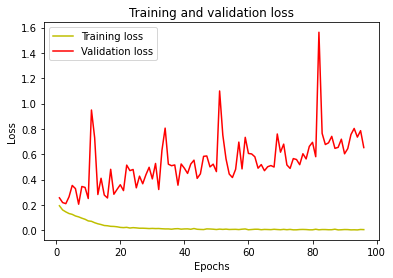

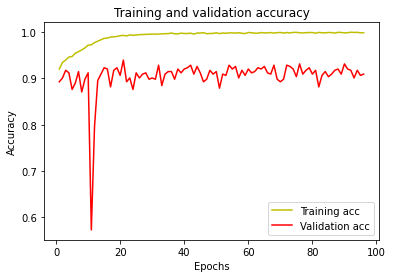

In [ ]:
# plotting

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


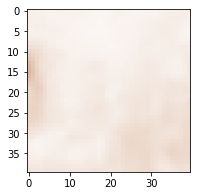

The prediction for this image is:  [[4.8440583e-08]]
The actual label for this image is:  0.0
12/12 [==============================] - 0s 5ms/step - loss: 0.3125 - accuracy: 0.9394
Accuracy =  93.9393937587738 %
[[205  15]
 [ 11 132]]
Recall =  0.9318181818181818
Precision =  0.9490740740740741
F_measure =  0.9403669724770641


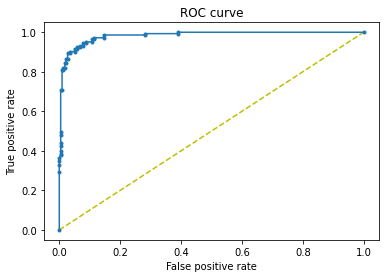

Ideal threshold is:  30    0.136178
Name: thresholds, dtype: float32
Area under curve, AUC =  0.9830896376350922


In [ ]:
n=45  #Select the index of image to be loaded for testing
img = (x_val[n]).astype(np.uint16)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.show()


input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_val[n])


_, acc = model.evaluate(x_val, y_val)
print("Accuracy = ", (acc * 100.0), "%")


################################################################
mythreshold = 0.14
################################################################


from sklearn.metrics import confusion_matrix

y_pred = (model.predict(x_val)>= mythreshold).astype(int)
cm = confusion_matrix(y_val, y_pred)  
print(cm)

Recall = (cm[0,0] / (cm[0,0] + cm[0,1]))
print("Recall = ", Recall)

Precision = (cm[0,0] / (cm[0,0] + cm[1,0]))
print("Precision = ", Precision)

F_measure = (2 * Recall * Precision) / (Recall + Precision)
print("F_measure = ", F_measure )


#ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(x_val).ravel()

fpr, tpr, thresholds = roc_curve(y_val, y_preds)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

"""
#One way to find the best threshold once we calculate the true positive 
and false positive rates is ...
The optimal cut off point would be where “true positive rate” is high 
and the “false positive rate” is low. 
Based on this logic let us find the threshold where tpr-(1-fpr) is zero (or close to 0)
"""
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 


#Area under the curve (AUC) for ROC plot 

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)
